# Experiment 2:  
This experiment implements optimization over model selection. Given an LSTNET model, we vary the following hyperparameters: inference period, batch size, and epochs. After running optimization, we will now have the parameters that trains a model with the best performance. In practice, as we come across a new set of parameters, we will train and save a new model. If those parameters are sampled again, we'll instead load the model. In the interest of time, we have pre-trained a handful of models and tightened the variance of the priors for faster inference. Also, in practice the number of hyperparameters varied should be increased. We have kept it at 3 for easier visualization. 

### Imports

In [1]:
from qbo import QBO
from qmc import QMC
import numpy as np
import pandas as pd
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeWashington
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from lstnet import LSTNet

import yfinance as yf
import seaborn as sns

### Download Data

In [2]:
data = yf.download("JPY=X", start="2022-01-01", end="2025-01-01")
historical_data = pd.DataFrame(data)
historical_data.to_csv("data/usdjpy.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
historical_data.head()

Price,Close,High,Low,Open,Volume
Ticker,JPY=X,JPY=X,JPY=X,JPY=X,JPY=X
Date,,,,,
2022-01-03,115.141998,115.360001,114.973999,115.136002,0
2022-01-04,115.328003,116.339996,115.299004,115.316002,0
2022-01-05,116.174004,116.235001,115.626999,116.165001,0
2022-01-06,116.127998,116.179001,115.653999,116.128998,0
2022-01-07,115.864998,116.029999,115.591003,115.870003,0


Text(0.5, 1.0, 'USD/JPY Close')

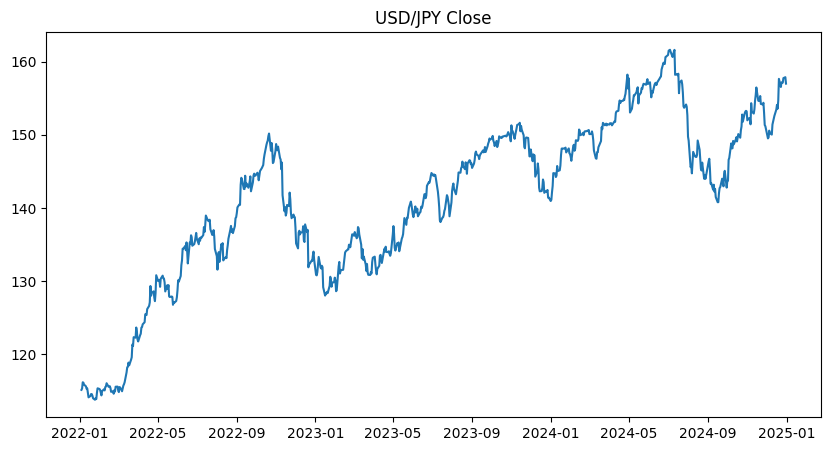

In [4]:
# Display closing price
# This is non-linear, non-stationary. Models WILL struggle to define relationships. Future datapoints could make gradients unstable
f = plt.figure(figsize=(10, 5))
plt.plot(historical_data["Close"].index, historical_data["Close"])
plt.title("USD/JPY Close")

Text(0.5, 1.0, 'USD/JPY Log-Return')

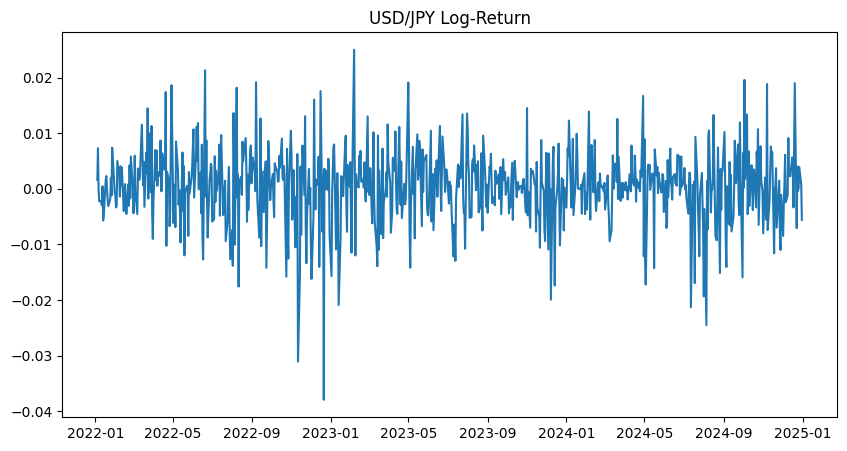

In [5]:
# Here, we compute the log returns. This allows the data to now be stationary
# This also creates a form of normalization, stabilizing gradients for future inputs
f = plt.figure(figsize=(10, 5))
y = np.log(historical_data["Close"].to_numpy()).squeeze()
y_delta = y[1:] - y[:-1]

plt.plot(historical_data["Close"].index[1:], y_delta)
plt.title("USD/JPY Log-Return")

### Experiment Config

In [6]:
# Quantum simulation device
device = FakeWashington()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)

# Quantum params
quantum_noise = False
max_iter = 5000 # 11s for 100, 10min on 5000 for experiment
total_runs = 5
uncertainty_dim = 6 # number of qubits to use (exponentially increases runtime) 6 is default

In [7]:
# Lookahead prior sampling
dim1 = np.linspace(0, 1, 3) # add these alongside prior domain. treat as arb gridspace
dim2 = np.linspace(0, 1, 3)
dim3 = np.linspace(0, 1, 3)
dim = 3
domain = []
for a in dim1:
    for b in dim2:
        for c in dim3:
            domain.append([a, b, c])
domain = np.array(domain)
ls = np.array([0.2] * dim) # length scale
v_kernel = 0.5
obs_noise = 0.05 ** 2
M_target = 200

# RBF kernel
s = np.random.multivariate_normal(np.zeros(dim), 1 / (ls ** 2) * np.identity(dim), M_target)
b = np.random.uniform(0, 2 * np.pi, M_target)

fourier_features = {
    "s": s, # frequencies
    "b": b, # phases
    "v_kernel": v_kernel,
    "obs_noise": obs_noise,
    "domain": domain
}

pbounds = {}
for i in range(dim):
    pbounds["x" + str(i+1)] = (0, 1)

ts = np.arange(1, max_iter)
beta_t = 1 + np.sqrt(np.log(ts) ** 2)

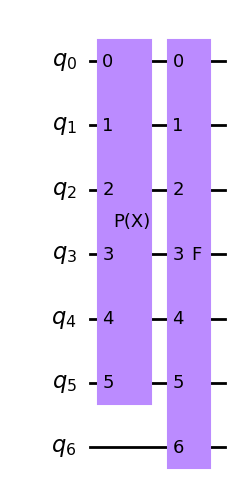

In [8]:
dummy_qmc = QMC(num_uncertainty=uncertainty_dim, means=1.0)
dummy_qmc.mc_circuit.draw(output="mpl")

### Data Loader

In [9]:
class USDJPY(Dataset):
    def __init__(self, data, period):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.period = period
    
    def __len__(self):
        return len(self.data) - self.period

    def __getitem__(self, index):
        x = self.data[index: index + self.period]
        y = self.data[index + self.period]
        return x, y

In [10]:
log_data = np.log(historical_data["Close"].to_numpy())
log_return_data = log_data[1:] - log_data[:-1]

### Model Priors and Test Loop

In [11]:
# Preloaded prior selection
periods = {0: 10, 1: 20, 2: 30}
batches = {0: 16, 1: 32, 2: 64}
epochs = {0: 100, 1: 500, 2: 1000}

In [12]:
def forecast(loader: DataLoader, model: nn.Module):
    model.eval()
    predictions = []
    with torch.no_grad():
        for sequences, _ in loader:
            preds = model(sequences)
            predictions.extend(preds.numpy())
    return np.asarray(predictions)

In [13]:
def reward_function(param, eps, obs_noise):    
    # Rescale
    parameter_range = [[0.0, 2.0], [0.0, 2.0], [0.0, 2.0]]
    period = periods[int(param[0] * (parameter_range[0][1] - parameter_range[0][0]) + parameter_range[0][0])]
    batch = batches[int(param[1] * (parameter_range[1][1] - parameter_range[1][0]) + parameter_range[1][0])]
    epoch = epochs[int(param[2] * (parameter_range[2][1] - parameter_range[2][0]) + parameter_range[2][0])]

    # Construct data loader and load corresponding model
    test_window = log_return_data[-(100 + period):]
    test_dataset = USDJPY(test_window, period=period)
    test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)
    model = LSTNet(period=period, num_features=1, rnn_dim=64, cnn_dim=64, skip_dim=32)
    model.load_state_dict(torch.load(f"models/{period}-{batch}-{epoch}.pth"))
    
    # Forecast test
    predictions = forecast(test_loader, model)
    mse = np.mean((predictions - test_window[period:]) ** 2)
    
    # Update beliefs via QBO and QMC
    qmc = QMC(num_uncertainty=uncertainty_dim, means=1-mse, obs_noise=obs_noise)
    result, queries = qmc.estimate(eps)
    return result.estimation_processed, 1-mse, queries

### Apply QBO with Q-GP-UCB

In [15]:
quantum_BO = None
linear = False
all_gp_res = []
for itr in range(total_runs):
    print("Optimization Round", itr + 1)
    np.random.seed(itr)

    quantum_BO = QBO(
        reward_func=reward_function,
        pbounds=pbounds,
        beta_t=beta_t,
        random_features=fourier_features,
        bandits=linear,
        domain=domain
    )
    quantum_BO.maximize(n_iter=max_iter, init_points=1)
    all_gp_res.append(quantum_BO.res)

Optimization Round 1
Shot 0 ------ x_t: [0.5 0.5 0.5], y_t: 1.0043529359015013
Shot 1 ------ x_t: [0.5 0.5 0.5], y_t: 1.0043529359015013
Shot 2 ------ x_t: [0.5 0.5 0.5], y_t: 1.0043529359015013
Shot 3 ------ x_t: [0.5 0.5 0.5], y_t: 1.0043529359015013
Shot 4 ------ x_t: [0.5 0.5 0.5], y_t: 1.0043529359015013
Shot 5 ------ x_t: [0.5 0.5 0.5], y_t: 1.0043529359015013
Shot 6 ------ x_t: [0.5 0.5 0.5], y_t: 1.0043529359015013
Shot 7 ------ x_t: [0.5 0.5 0.5], y_t: 1.0078218513797412
Shot 8 ------ x_t: [0.5 0.5 0.5], y_t: 1.0077219083635043
Shot 9 ------ x_t: [0.5 0.5 0.5], y_t: 1.0065721660325717
Shot 10 ------ x_t: [0.5 0.5 0.5], y_t: 1.0049495092200642
Shot 11 ------ x_t: [0.5 0.5 0.5], y_t: 1.0066104387929822
Shot 12 ------ x_t: [0.5 0.5 0.5], y_t: 1.0016154521454874
Shot 13 ------ x_t: [0.5 0.5 0.5], y_t: 1.0019140991231616
Shot 14 ------ x_t: [0.5 0.5 0.5], y_t: 1.0018661539633427
Shot 15 ------ x_t: [0.5 0.5 0.5], y_t: 1.0007959020188057
Shot 16 ------ x_t: [0.5 0.5 0.5], y_t: 1.000

### Param Distribution

In [16]:
# Retrieve collective param results. Rescale
parameter_range = [0.0, 2.0] # unique for this, since all params have same range

# Individual param distributions
x1_dist = {periods[k]: 0 for k in range(3)}
x2_dist = {batches[k]: 0 for k in range(3)}
x3_dist = {epochs[k]: 0 for k in range(3)}
for gp_res in all_gp_res:
    for param in gp_res["all"]["params"]:
        # Rescale
        param = (param * (parameter_range[1] - parameter_range[0]) + parameter_range[0]).astype("int")
        # Frequencies
        x1, x2, x3 = periods[param[0]], batches[param[1]], epochs[param[2]]
        for xn, dist in zip([x1, x2, x3], [x1_dist, x2_dist, x3_dist]):
            dist[xn] += 1

# Relational param distribution
param_dist = {}
for gp_res in all_gp_res:
    for param in gp_res["all"]["params"]:
        # Rescale
        param = (param * (parameter_range[1] - parameter_range[0]) + parameter_range[0]).astype("int")
        param[0] = periods[param[0]]
        param[1] = batches[param[1]]
        param[2] = epochs[param[2]]
        # Frequencies
        param = tuple(param.tolist())
        if param not in param_dist:
            param_dist[param] = 0
        param_dist[param] += 1
    
print(x1_dist)
print(x2_dist)
print(x3_dist)
print(param_dist)

{10: 0, 20: 74, 30: 18}
{16: 18, 32: 74, 64: 0}
{100: 18, 500: 56, 1000: 18}
{(20, 32, 500): 38, (20, 32, 100): 18, (20, 16, 500): 18, (30, 32, 1000): 18}


In [17]:
# Extract frequencies
x1_samples = []
x2_samples = []
x3_samples = []    
for value, freq in x1_dist.items():
    x1_samples.extend([value] * freq)
for value, freq in x2_dist.items():
    x2_samples.extend([value] * freq)
for value, freq in x3_dist.items():
    x3_samples.extend([value] * freq)

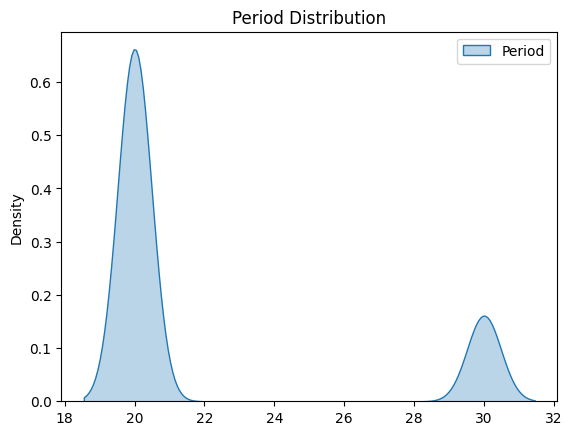

In [18]:
# KDE plot
sns.kdeplot(x1_samples, bw_adjust=0.3, fill=True, label="Period", alpha=0.3)

# Axis labels
plt.title("Period Distribution")
plt.legend()

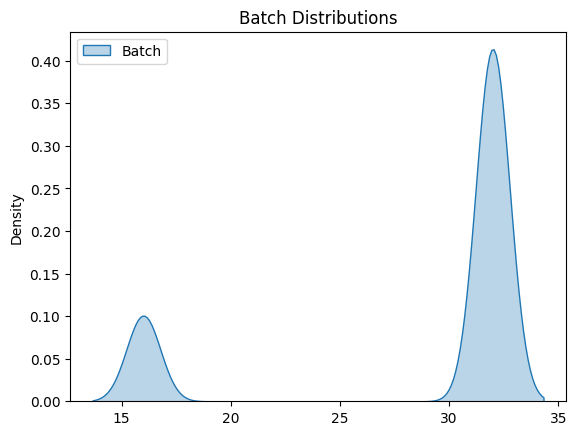

In [19]:
# KDE plot
sns.kdeplot(x2_samples, bw_adjust=0.3, fill=True, label="Batch", alpha=0.3)

# Axis labels
plt.title("Batch Distributions")
plt.legend()

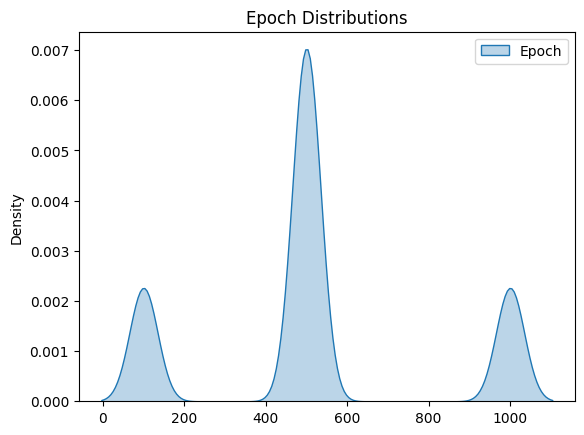

In [20]:
# KDE plot
sns.kdeplot(x3_samples, bw_adjust=0.3, fill=True, label="Epoch", alpha=0.3)

# Axis labels
plt.title("Epoch Distributions")
plt.legend()

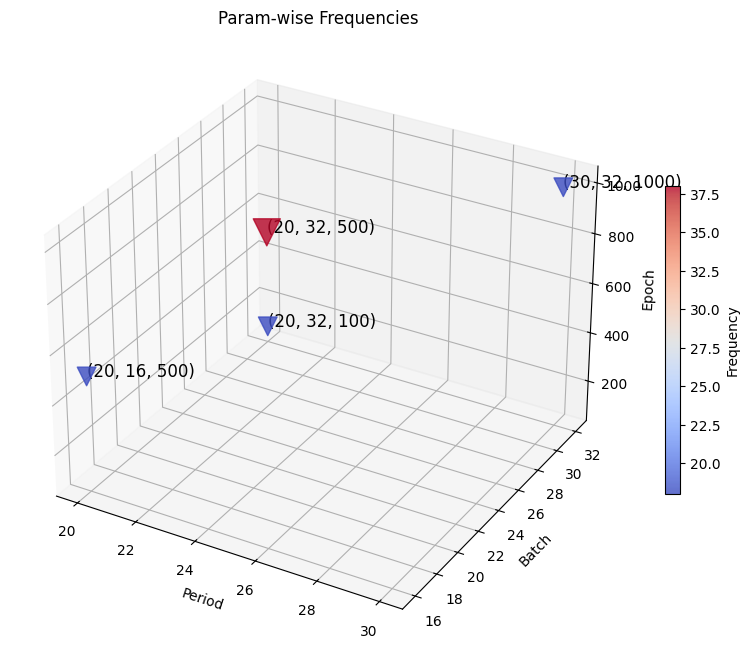

In [ ]:
# Extract coordinates and frequencies
x = [key[0] for key in param_dist]
y = [key[1] for key in param_dist]
z = [key[2] for key in param_dist]
freq = list(param_dist.values())

# Set up 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use frequency as size or color
scatter = ax.scatter(x, y, z, c=freq, s=[f * 10 for f in freq], cmap='coolwarm', alpha=0.8, marker="v")

# Annotate each point with its coordinates
for xi, yi, zi in zip(x, y, z):
    ax.text(xi, yi, zi, f'({xi}, {yi}, {zi})', size=12, zorder=1, color='black')

# Colorbar to show frequency scale
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
cbar.set_label('Frequency')

# Axis labels
ax.set_xlabel('Period')
ax.set_ylabel('Batch')
ax.set_zlabel('Epoch')
ax.set_title('Param-wise Frequencies')

plt.show()

### True Best Params

In [22]:
parameter_range = [0.0, 2.0] # unique for this, since all params have same range
max_params = {}
for gp_res in all_gp_res:
    val, params = gp_res["max"]["max_val"], gp_res["max"]["max_params"]
    params = [(p * (parameter_range[1] - parameter_range[0]) + parameter_range[0]).astype("int") for p in params.values()]
    params[0] = periods[params[0]]
    params[1] = batches[params[1]]
    params[2] = epochs[params[2]]
    max_params[val] = params

best_params = max_params[max(max_params.keys())]
print("Confidence:", max(max_params.keys()))
print("Params (Period, Batch, Epoch):", best_params)

Confidence: 1.0097106587081885
Params (Period, Batch, Epoch): [20, 16, 500]


### Test Model

In [23]:
# Retrieve best params and relevant dataset, model
period, batch, epoch = best_params
test_window = log_return_data[-(100 + period):]
test_dataset = USDJPY(test_window, period=period)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)
model = LSTNet(period=period, num_features=1, rnn_dim=64, cnn_dim=64, skip_dim=32)
model.load_state_dict(torch.load(f"models/{period}-{batch}-{epoch}.pth"))

# Forecast
predictions = forecast(test_loader, model)
mse = np.mean((predictions - test_window[period:]) ** 2)
print("MSE:", mse)

MSE: 6.849921082464174e-05


Text(0.5, 1.0, 'Out of Sample USD/JPY Log-Return')

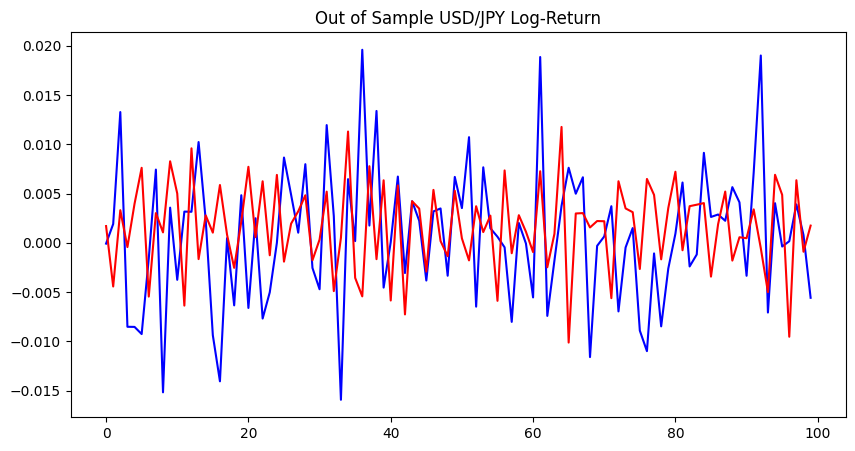

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(test_window) - period), test_window[period:], color="blue")
plt.plot(np.arange(len(predictions)), predictions, color="red")
plt.title("Out of Sample USD/JPY Log-Return")

In [25]:
test_window = log_return_data[:-100]
test_dataset = USDJPY(test_window, period=period)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)
model = LSTNet(period=period, num_features=1, rnn_dim=64, cnn_dim=64, skip_dim=32)
model.load_state_dict(torch.load(f"models/{period}-{batch}-{epoch}.pth"))

# Forecast
predictions = forecast(test_loader, model)
mse = np.mean((predictions - test_window[period:]) ** 2)
print("MSE:", mse)

MSE: 6.619500308010273e-05


Text(0.5, 1.0, 'In Sample USD/JPY Log-Return')

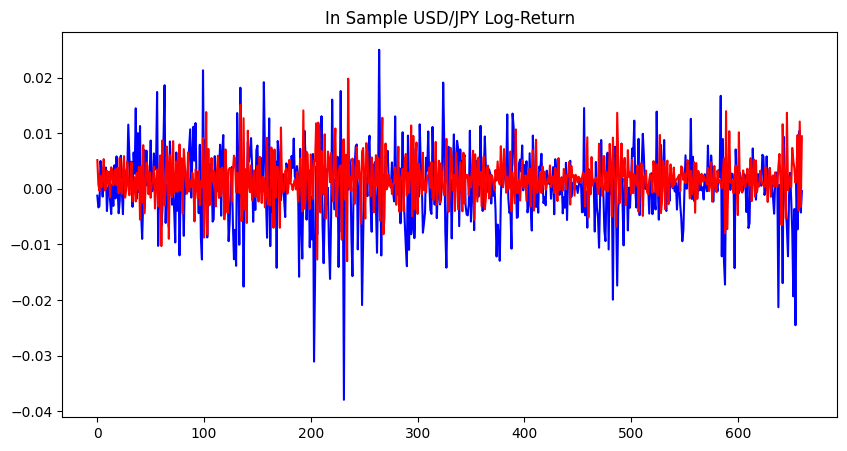

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(test_window) - period), test_window[period:], color="blue")
plt.plot(np.arange(len(predictions)), predictions, color="red")
plt.title("In Sample USD/JPY Log-Return")